In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm

tf.compat.v1.enable_v2_behavior()

from curiosity import m_passthrough_action

import pixiedust
from functools import partial

Pixiedust database opened successfully


In [3]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

In [4]:
def matrix_dist(A, B):
    return np.linalg.norm((A - B).flatten(), ord=1)

In [5]:
# "model of the environment"
A = np.array([
    [1,0,1,0], # state and action, gives s_1
    [0,1,0,1],
])

# number of actions
n_a = 2

# number of state components
n_s = 2

# number of observation components
n_o = 2

# number of features
n_f = 2

# transform for the state
Q1 = np.random.randn(2, 2)

# transform for state+action
Q = np.eye(4)
Q[:2, :2] = Q1

# number of data pts
N = 1000

# states
xs = np.random.randn(4, N)

# next states
ys = A @ xs

xs_e = Q @ xs
ys_e = Q1 @ ys

# states
xs = xs.T
ys = ys.T

# observations
xs_e = xs_e.T
ys_e = ys_e.T

In [6]:
assert xs.shape[1] == n_s + n_a
assert ys.shape[1] == n_s
assert xs_e.shape[1] == n_o + n_a
assert ys_e.shape[1] == n_o

In [7]:
# checking that the model works correctly
assert np.allclose(A @ (np.linalg.inv(Q) @ xs_e[0]), ys[0])
assert np.allclose(xs_e[0][2:], xs[0][2:])

1000/1000 [==============================] - 0s 38us/sample - loss: 0.0078
0.00784166705608368
[<tf.Variable 'sequential/dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[ 9.9999863e-01, -3.5294358e-04],
       [ 1.3998902e-05,  9.5111418e-01],
       [ 9.9984759e-01,  6.8431254e-05],
       [-1.1670074e-05,  8.8318318e-01]], dtype=float32)>, <tf.Variable 'sequential/dense/bias:0' shape=(2,) dtype=float32, numpy=array([3.8402723e-07, 5.4356933e-04], dtype=float32)>]
0.1663034648026951


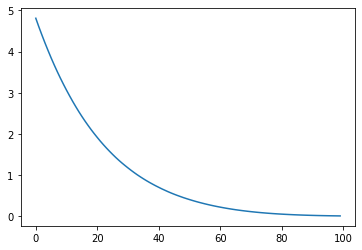

In [8]:
# checking that data is correctly generated
m = tf.keras.Sequential([tf.keras.layers.Dense(2)])
m.compile('adam', 'mse')
h = m.fit(xs, ys, epochs=100, verbose=0)
plt.plot(h.history['loss'])
print(m.evaluate(xs, ys))
print(m.weights)
print(matrix_dist(m.weights[0].numpy().T, A))

In [9]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    if np.linalg.norm(v) <= z:
        return v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [10]:
projection_simplex_sort(np.array([1,0.1]), 3)

array([1. , 0.1])

In [11]:
class MaxNorm1(tf.keras.constraints.Constraint):
  def __init__(self, max_value=2, axis=0):
    self.max_value = max_value
    self.axis = axis

  def __call__(self, w):
    norms = K.sqrt(
        math_ops.reduce_sum(math_ops.square(w), axis=self.axis, keepdims=True))
    desired = K.clip(norms, 0, self.max_value)
    return w * (desired / (K.epsilon() + norms))

  def get_config(self):
    return {'max_value': self.max_value, 'axis': self.axis}

In [16]:
#%%pixie_debugger

# l1 parameters
l1coeff = 0

# for reconstructor
#l2coeff = 0

# for keras sparsity
sparsity = 0.3
pruning_params = {
        'pruning_schedule': pruning_sched.ConstantSparsity(0.9, 0),
        #'pruning_schedule': pruning_sched.PolynomialDecay(0, 0.3, 0, 100),
        'block_size': (1, 1),
        'block_pooling_type': 'AVG'
    }

def component_diff_normalized(v):
    """How much the vector is close to (1,0) or (0,1)."""
    v = np.abs(v)
    return 1. - (max(v) - min(v)) / max(v)

def vec_angle_normalized(v1, v2):
    """Cos betweeen vectors."""
    return np.abs(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

def repr_quality(A):
    """Loss for representation quality for matrix A."""
    [s_1, s_2] = A.T # basis vectors = columns
    return component_diff_normalized(s_1) + \
           component_diff_normalized(s_2) + \
           vec_angle_normalized(s_1, s_2)

def build_decoder_model(input_layer, init_fp_dist=None):
    """Create a decoder model."""
    decoder = tf.keras.Sequential([ #D
        input_layer,
        tf.keras.layers.Dense(2, activation=None, use_bias=False, #kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                             #kernel_initializer='random_normal',
                             #kernel_constraint=tf.keras.constraints.UnitNorm()
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(0.5, 1.5) # == 1 -- 
                             ),
    ])
    
    if init_fp_dist is not None:
        decoder.layers[-1].set_weights([np.linalg.inv(Q1).T +\
                                        np.ones((2, 2)) * init_fp_dist])
    return decoder

def build_reconstructor_model(init_fp_dist=None):
    """Build the reconstructor."""
    # encoder model -- imitates the RL agent which has converged to something -- and needs to reconstruct the state
    # but the policy is "fixed" and the reward = max
    reconstructor = tf.keras.Sequential([ # E
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(2, activation=None, use_bias=False, #kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                             #kernel_initializer='random_normal',
                             #kernel_constraint=tf.keras.constraints.UnitNorm()
                              
                             # how can we take the scale out of this -- decompose 
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(0.5, 1.5)
                             ),
    ])
    
    if init_fp_dist is not None:
        reconstructor.layers[-1].set_weights([Q1.T + np.ones((2, 2)) * init_fp_dist])
        #reconstructor.layers[-1].set_weights([np.linalg.inv(decoder.get_weights()[0])])

    return reconstructor

def build_feature_model(decoder, init_fp_dist=None):
    """Build the feature transition dynamics model."""
    # maps observations to features
    model = tf.keras.Sequential([ # M
        m_passthrough_action(decoder, 2, 2), # D
        tf.keras.Input(shape=(4,)),
        #prune.prune_low_magnitude(
            tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_regularizer=tf.keras.regularizers.l1(l1coeff),
                                 #kernel_initializer='random_normal'
                                 ), # M_D
        #**pruning_params)
    ])
    
    if init_fp_dist is not None:
        model.layers[-1].set_weights([A.T + np.ones((4, 2)) * init_fp_dist])
    return model

def loss_model_fit(y_true, y_pred, decoder=None, sample_weight=None):
    """How well the model fits the data?"""
    del sample_weight
    # y_pred = from the model 
    L = tf.reduce_mean(tf.abs(y_pred - decoder(y_true)))
    return L

def loss_reconstructor(reconstructor, decoder, x):
    """How well the reconstructor can obtain observations?"""
    # x is the input tensor (observations)
    if x is None: return 0
    x = x[:, :2]
    L = tf.reduce_mean(tf.abs(reconstructor(decoder(x)) - x))
    return L

def step(model, decoder, reconstructor, xs, ys, optimizer, l_rec_coeff=1):
    """One optimization step."""
    # xs - observations + actions
    # ys - next observations
    
    # converting dtype
    xs = np.array(xs, dtype=np.float32)
    ys = np.array(ys, dtype=np.float32)
    
    with tf.GradientTape() as tape:
        # Make prediction
        y_pred = model(xs)
        
        # Calculate loss
        l_fit = loss_model_fit(ys, y_pred, decoder=decoder)
        l_rec = loss_reconstructor(reconstructor=reconstructor,
                                   decoder=decoder, x=xs)

        # total loss
        model_loss = l_fit + l_rec_coeff * l_rec
        
    # Calculate gradients
    model_gradients = tape.gradient(model_loss, model.trainable_variables)
    
    # Update model
    optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))
    return {'l_fit': l_fit.numpy(), 'l_rec': l_rec.numpy()}

def arr_of_dicts_to_dict_of_arrays(arr):
    """ Array of dicts to dict of arrays """
    all_keys = arr[0].keys()
    return {key: [v[key] for v in arr] for key in all_keys}

def get_results(eps_d=None, eps_m=None, eps_r=None, batch_size=16, epochs=1, optimizer=None,
               l_rec_coeff=1):
    """Compute results."""
    # input for the decoder (features)
    inp_dec = tf.keras.Input(shape=(2,))
    
    # defining models
    decoder = build_decoder_model(inp_dec, init_fp_dist=eps_d)
    model = build_feature_model(decoder, init_fp_dist=eps_m)
    reconstructor = build_reconstructor_model(init_fp_dist=eps_r)
    
    # compiling
    model.compile(optimizer='adam', loss=partial(loss_model_fit,
                                                decoder=decoder))
    model.optimizer = optimizer
    
    # for weight pruning
    #step_callback = pruning_callbacks.UpdatePruningStep()
    #step_callback.set_model(model)
    #step_callback.on_train_begin()
   
    losses = []
    distances = []
    
    def evaluate_dist():
        """Evaluate the models."""
        DE = decoder.weights[0].numpy().T @ Q1
        distances.append(repr_quality(DE))
    
    # training mechanics
    x_train = xs_e
    y_train = ys_e
    bat_per_epoch = int(len(x_train) / batch_size)
    
    # evaluate the quality
    evaluate_dist()
    
    # epoch loop
    with tqdm(total=epochs) as pbar:
      for epoch in range(epochs):
        L = []
        
        # one epoch
        #with tqdm(total=bat_per_epoch, leave=False) as pbar1:
        for i in range(bat_per_epoch):
            #step_callback.on_train_batch_begin(batch=-1)
            n = i * batch_size
            loss = step(model=model, decoder=decoder,
                          reconstructor=reconstructor,
                          xs=x_train[n:n+batch_size],
                          ys=y_train[n:n+batch_size],
                          optimizer=optimizer,
                          l_rec_coeff=l_rec_coeff)
            L.append(loss)
            
            # hard sparsity
            #l = model.layers[-1]
            #w = l.get_weights()[0]
            #w[np.abs(w) < 1e-1] = 0
            #l.set_weights([w])
            
            # keras sparsity
            #step_callback.on_train_batch_end(batch=i)
            #pbar1.update(1)
            
        # keras sparsity
        #step_callback.on_epoch_end(batch=-1)
        #step_callback.on_epoch_end(-1)
        #print(model.get_weights())

        # adding metrics
        L = arr_of_dicts_to_dict_of_arrays(L)
        curr_loss = {x: np.mean(y) for x, y in L.items()}
        losses.append(curr_loss)
        evaluate_dist()
        pbar.set_description(str(curr_loss))
        pbar.update(1)
        
    # final evaluation
    losses = arr_of_dicts_to_dict_of_arrays(losses)
    loss = model.evaluate(xs_e, ys_e, verbose=0)
    losses['l_fit'].append(loss)
    
    return losses, distances, model, reconstructor

First success -- try with 1e-2 for ED and 5e-1 for the M

In [18]:
# "distance" from the correct fixed point
eps = {'m': 1e-3, 'd': 1e-3, 'r': 1e-3} # eps=0... -- very small distance DE-I

In [19]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [22]:
res = get_results(epochs=300, batch_size=64, optimizer=optimizer, l_rec_coeff=5)
losses, distances, model, reconstructor = res

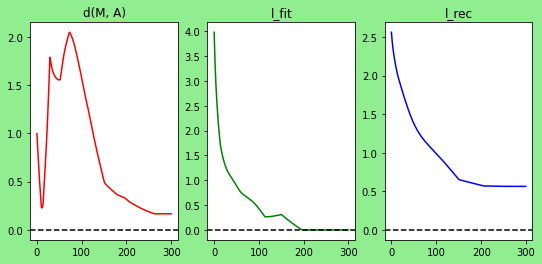

In [23]:
# Plotting everything
fig = plt.figure(figsize=(9, 4))
fig.patch.set_facecolor('lightgreen')

N_plots = len(losses) + 1

plt.subplot(1, N_plots, 1)
plt.title("d(M, A)")
plt.plot(distances, color='red')
plt.axhline(0, ls='--', c='black')

colormap = ['green', 'blue']

# model losses
for i, key in enumerate(losses.keys()):
    plt.subplot(1, N_plots, 2 + i)
    plt.title(key)
    plt.plot(losses[key], c=colormap[i])
    plt.axhline(0, ls='--', c='black')

#plt.legend()
plt.show()

In [138]:
l1regs = np.logspace(-5, -3, 5)
repetitions = 2

  0%|          | 0/200 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 32%|███▏      | 64/200 [00:25<00:54,  2.50it/s]


KeyboardInterrupt: 

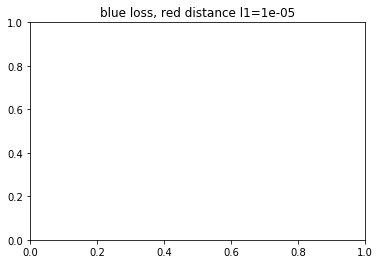

In [323]:
for l1 in l1regs:
    plt.figure()
    plt.title("blue loss, red distance l1=%s" % str(l1))
    for _ in range(repetitions):
        losses, distances, _, _, _ = get_results(l1)
        plt.plot(losses, color='blue')
        plt.plot(distances, color='red')
    plt.axhline(0)
    plt.ylim(0, 10)
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


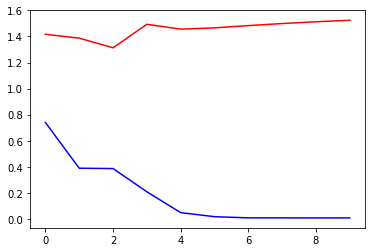

In [172]:
losses, distances, model, DE, enc_model = get_results(1e-3)
plt.plot(losses, color='blue')
plt.plot(distances, color='red')

How to regularize foe the number of non-zero elements? Use SparseSep instead of l1 https://arxiv.org/pdf/1701.06967.pdf

How to evaluate the transform $DE=?$ it should be the right vectors, but they can be scaled and permuted. Therefore, we use the following metric: L1+L2+L3, where L1=difference between two components for first vector, L2 for the second and L3 the dot product between the two (should be 0)

add constraint on mean/variance of features?